# 3.1 线性回归

回归（regression）是能为⼀个或多个⾃变量与因变量之间关系建模的⼀类⽅法。在⾃然科学和社会科学领域，回归经常⽤来表⽰输⼊和输出之间的关系。在机器学习领域中的⼤多数任务通常都与预测（prediction）有关。当我们想预测⼀个数值时，就会涉及到回归问题。常⻅的例⼦包括：预测价格（房屋、股票等）、预测住院时间（针对住院病⼈等）、预测需求（零售销量等）。但不是所有的预测都是回归问题。在后⾯的章节中，我们将介绍分类问题。分类问题的⽬标是预
测数据属于⼀组类别中的哪⼀个。

## 3.1.1 线性回归的基本元素

### 3.1.1.1 线性模型

线性假设是指⽬标（房屋价格）可以表⽰为特征（⾯积和房龄）的加权和，如下⾯的式⼦

$price = w_{area}\cdot area + w_{age}\cdot age + b    (3.1.1)$

的warea和wage 称为权重（weight），权重决定了每个特征对我们预测值的影响。b称为偏置（bias）、
偏移量（offset）或截距（intercept）。偏置是指当所有特征都取值为0时，预测值应该为多少。即使现实中不
会有任何房⼦的⾯积是0或房龄正好是0年，我们仍然需要偏置项。如果没有偏置项，我们模型的表达能⼒将
受到限制。严格来说，(3.1.1)是输⼊特征的⼀个 仿射变换（affine transformation）。仿射变换的特点是通过
加权和对特征进⾏线性变换（linear transformation），并通过偏置项来进⾏平移（translation）。


### 3.1.1.2 损失函数
在我们开始考虑如何用模型拟合（fit）数据之前，我们需要确定一个拟合程度的度量。 损失函数（loss function）能够量化目标的实际值与预测值之间的差距。 通常我们会选择非负数作为损失，且数值越小表示损失越小，完美预测时的损失为0。 回归问题中最常用的损失函数是平方误差函数。 当样本i的预测值为$\hat{y}^{i}$，其相应的真实标签为$y^{i}$时， 平方误差可以定义为以下公式

$l^{i}(w,b) = \frac{1}{2}(\hat{y}^{i},y^{i})^{2}$

### 3.1.1.3 解析解
线性回归刚好是一个很简单的优化问题。 与我们将在本书中所讲到的其他大部分模型不同，线性回归的解可以用一个公式简单地表达出来， 这类解叫作解析解（analytical solution）。


### 3.1.1.4 随机梯度下降
梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值） 关于模型参数的导数（在这里也可以称为梯度）。 但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。 因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）


线性回归恰好是一个在整个域中只有一个最小值的学习问题。 但是对像深度神经网络这样复杂的模型来说，损失平面上通常包含多个最小值。 深度学习实践者很少会去花费大力气寻找这样一组参数，使得在训练集上的损失达到最小。 事实上，更难做到的是找到一组参数，这组参数能够在我们从未见过的数据上实现较低的损失， 这一挑战被称为泛化（generalization）。


### 3.1.1.5 使用模型进行预测
给定“已学习”的线性回归模型$\hat{w}^{T}x + \hat{b}$， 现在我们可以通过房屋面积$x_1$和房龄$x_2$来估计一个（未包含在训练数据中的）新房屋价格。 给定特征估计目标的过程通常称为预测（prediction）或推断（inference）

## 3.1.2 矢量化加速
在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。 为了实现这一点，需要我们对计算进行矢量化， 从而利用线性代数库，而不是在Python中编写开销高昂的for循环。

为了说明矢量化为什么如此重要，我们考虑对向量相加的两种方法。 我们实例化两个全为1的10000维向量。 在一种方法中，我们将使用Python的for循环遍历向量； 在另一种方法中，我们将依赖对+的调用。

In [1]:
import math
import time
import numpy as np
import torch

n = 10000
a = torch.ones([n])
b = torch.ones([n])

考虑到将频繁地进行运行时间的基准测试，所以我们定义一个计时器：

In [9]:
class Timer(object):
    '''记录多次运行时间'''
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        '''启动计时器'''
        self.tik = time.time()
    
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

for 循环进行时间计数

In [10]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'   

'0.09953 sec'

使用重载的+运算符来计算按元素的和

In [11]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## 3.1.3 正态分布与平方损失
通过对噪声分布的假设来解读平方损失目标函数。正态分布和线性回归之间的关系很密切。 正态分布（normal distribution），也称为高斯分布（Gaussian distribution）， 最早由德国数学家高斯（Gauss）应用于天文学研究。 简单的说，若随机变量$x$具有均值$\mu$和方差$\sigma^{2}$（标准差），其正态分布概率密度函数如下：
$p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{1}{2\sigma^2}(x-\mu)^2)$

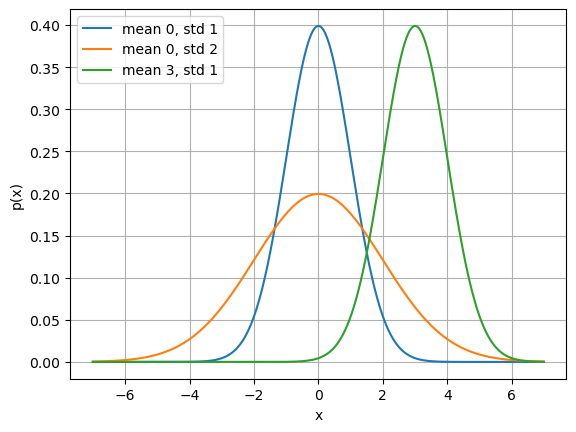

In [25]:
def normal(x,mu,sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x- mu)**2)

import matplotlib.pyplot as plt
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
for mu, sigma in params:
    plt.plot(x, [normal(i, mu, sigma) for i in x],label=f'mean {mu}, std {sigma}')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("p(x)")
    plt.grid(True, linestyle='-')
plt.show()

就像我们所看到的，改变均值会产生沿轴的偏移，增加方差将会分散分布、降低其峰值。

均方误差损失函数（简称均方损失）可以用于线性回归的一个原因是： 我们假设了观测中包含噪声，其中噪声服从正态分布。 噪声正态分布如下式: